# [Adult] -- Open Trained Forest Models & Plot

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import sys
# cwd = '/home/ec2-user/SageMaker/imputation-fairness/data/Adult/code'
cwd = '../../../core'
sys.path.append(cwd)

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from load_adult import * 
from treeutils import *
from missing_module import * 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer


from IPython.display import display, HTML

from itertools import combinations


## Load Data

In [63]:
### Loading Data ### 

filename = 'pkl_data/adult_ms.pkl'

with open(filename, 'rb') as handle: 
    data = pickle.load(handle)
    
X_orig = data['X']
y_orig = data['y']
m_orig = data['m']
S_orig = data['S']


<br/>

## Open Forest Files & Get Performance Metrics

In [64]:
lambda_list1 = [0.1, 0.5, 0.8, 2.0]
lambda_list2 = [0.14, 0.17]
lambda_list = sorted(lambda_list1+lambda_list2)
batch_size = 200
fair = 'fpr'
num_tree = 30
D=3


ens_acc_mean, ens_acc_std = [], []
ens_fr_mean, ens_fr_std = [], []


for lambd in lambda_list:
    acc_list = []
    fr_list = []

    for seed in range(1, 11):
        if lambd in lambda_list1:
            output_file = 'forests/d3trees_seed{}/{}_L{:.1f}_N{}_b{}.pkl'.format(seed, fair, lambd, num_tree, batch_size)
        else: 
            output_file = 'forests/d3trees_seed{}/{}_L{:.2f}_N{}_b{}.pkl'.format(seed, fair, lambd, num_tree, batch_size)

        with open(output_file, 'rb') as handle: 
            sol_trees = pickle.load(handle)

        forest = sol_to_forest(sol_trees, D)
        
        X_train, X_test, y_train, y_test, m_train, m_test, S_train, S_test = train_test_split(X_orig, y_orig, m_orig, S_orig, test_size=0.3, random_state=seed)
        
        X_test_temp = np.nan_to_num(X_test, nan=-999) # Filling in dummy values temporarily
        y_hat = forest.predict(X_test_temp, m_test)
        ens_acc = binary_score(y_test, y_hat)
        ens_fr = np.abs(binary_score(y_test[S_test==0], y_hat[S_test==0], fair) 
                        - binary_score(y_test[S_test==1], y_hat[S_test==1], fair))

        acc_list.append(ens_acc)
        fr_list.append(ens_fr)

    ens_acc_mean.append(np.mean(acc_list)) 
    ens_acc_std.append(np.std(acc_list))
    ens_fr_mean.append(np.mean(fr_list)) 
    ens_fr_std.append(np.std(fr_list))



<br/>

### Plot the Result

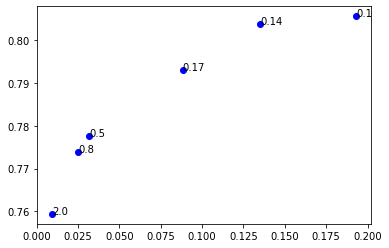

In [65]:

plt.scatter(ens_fr_mean, ens_acc_mean, color='blue')

annotations = [str(x) for x in lambda_list]
for i, label in enumerate(annotations):
    plt.annotate(label, (ens_fr_mean[i], ens_acc_mean[i]))


## Save the Fair MIP Forest Result

In [66]:
C = np.sqrt(10)
ens_acc_se, ens_fr_se = ens_acc_std/C, ens_fr_std/C

with open('results/fair_mip_result3.pkl', 'wb+') as f: 
    pickle.dump({'fr_mean': ens_fr_mean, 'fr_se': ens_fr_se, 
                 'acc_mean': ens_acc_mean, 'acc_se': ens_acc_se, 
                'lambda':lambda_list}, f)

## Plotting With Other Baselines

### Get the Baseline Results

#### 1. Baseline -- Mean Imputation


In [85]:
mean_acc_list = []
mean_fr_list =[]
for seed in range(1, 11):
    X_train, X_test, y_train, y_test, m_train, m_test, S_train, S_test = train_test_split(X_orig, y_orig, m_orig, S_orig, test_size=0.3, random_state=seed)
    imp_mean = SimpleImputer(strategy='mean')
    imp_mean.fit(X_train)
    X_train_imp = imp_mean.transform(X_train)
    X_test_imp = imp_mean.transform(X_test)
    base_tree = DecisionTreeClassifier(max_depth=3)
    base_tree.fit(X_train_imp, y_train)
    base_acc = binary_score(y_test, base_tree.predict(X_test_imp))
    mean_acc_list.append(base_acc)

    base_fr = np.abs(binary_score(y_test[S_test==0], base_tree.predict(X_test_imp[S_test==0]), metric=fair)
                 -binary_score(y_test[S_test==1], base_tree.predict(X_test_imp[S_test==1]), metric=fair))
    mean_fr_list.append(base_fr)

    print(base_acc, base_fr)

C = np.sqrt(10)
mean_fr_mean = np.mean(mean_fr_list)
mean_acc_mean = np.mean(mean_acc_list)
mean_fr_se = np.std(mean_fr_list)/C
mean_acc_se = np.std(mean_acc_list)/C

0.8073160357294769 0.10672750351641566
0.8102934921310081 0.0963189107625364
0.8043385793279455 0.10158594576970148
0.8136962994470438 0.3970766303407715
0.8102934921310081 0.4058893954045218
0.8132709485325393 0.396782602569221
0.8085920884729902 0.13085966794734233
0.8081667375584858 0.40125152625152627
0.8043385793279455 0.09314186737822717
0.8230540195661421 0.0859211849767037


#### 2. Baseline -- KNN Imputation


In [80]:
knn_acc_list = []
knn_fr_list =[]
for seed in range(1, 11):
    X_train, X_test, y_train, y_test, m_train, m_test, S_train, S_test = train_test_split(X_orig, y_orig, m_orig, S_orig, test_size=0.3, random_state=seed)
    imp_knn = KNNImputer()
    imp_knn.fit(X_train)
    X_train_imp = imp_knn.transform(X_train)
    X_test_imp = imp_knn.transform(X_test)
    base_tree = DecisionTreeClassifier(max_depth=3)
    base_tree.fit(X_train_imp, y_train)
    base_acc = binary_score(y_test, base_tree.predict(X_test_imp))
    knn_acc_list.append(base_acc)

    base_fr = np.abs(binary_score(y_test[S_test==0], base_tree.predict(X_test_imp[S_test==0]), metric=fair)
                 -binary_score(y_test[S_test==1], base_tree.predict(X_test_imp[S_test==1]), metric=fair))
    knn_fr_list.append(base_fr)

    print(base_acc, base_fr)

C = np.sqrt(10)
knn_fr_mean = np.mean(knn_fr_list)
knn_acc_mean = np.mean(knn_acc_list)
knn_fr_se = np.std(knn_fr_list)/C
knn_acc_se = np.std(knn_acc_list)/C

0.7898766482347938 0.463880979336055
0.792854104636325 0.1616521037302172
0.7894512973202893 0.42579900025946416
0.8034878774989366 0.45351150320013833
0.7941301573798384 0.4509669843901092
0.8051892811569545 0.4322138982175148
0.7949808592088473 0.4395001903707037
0.7915780518928116 0.4269879426129426
0.8005104210974053 0.3632469629941718
0.8034878774989366 0.39962518436328703


In [83]:
mean_acc_mean

0.7965546575925139

In [84]:
knn_acc_mean

0.7965546575925139

### Open Results Files

In [76]:
mip_result = pickle.load(open('results/fair_mip_result3.pkl', 'rb'))
exp_result = pickle.load(open('results/mean_exp_grad_result.pkl', 'rb'))
knn_exp_result = pickle.load(open('results/knn_exp_grad_result.pkl', 'rb'))
disp_mis_result = pickle.load(open('results/mean_disp_mistrtment_result.pkl', 'rb'))
knn_disp_mis_result = pickle.load(open('results/knn_disp_mistrtment_result.pkl', 'rb'))
eqodds_result = pickle.load(open('results/mean_eqodds_result.pkl', 'rb'))
knn_eqodds_result = pickle.load(open('results/knn_eqodds_result.pkl', 'rb'))

## Convert standard deviation to standard error ## 
exp_result['acc_se'], exp_result['fr_se']  = exp_result['fr_std']/C, exp_result['acc_std']/C
knn_exp_result['acc_se'], knn_exp_result['fr_se']  = knn_exp_result['fr_std']/C, knn_exp_result['acc_std']/C
disp_mis_result['acc_se'], disp_mis_result['fr_se']  = disp_mis_result['fr_std']/C, disp_mis_result['acc_std']/C
knn_disp_mis_result['acc_se'], knn_disp_mis_result['fr_se']  = knn_disp_mis_result['fr_std']/C, knn_disp_mis_result['acc_std']/C
eqodds_result['acc_se'], eqodds_result['fr_se']  = eqodds_result['fr_std']/C, eqodds_result['acc_std']/C
knn_eqodds_result['acc_se'], knn_eqodds_result['fr_se']  = knn_eqodds_result['fr_std']/C, knn_eqodds_result['acc_std']/C

Text(0.5, 1.0, 'Adult')

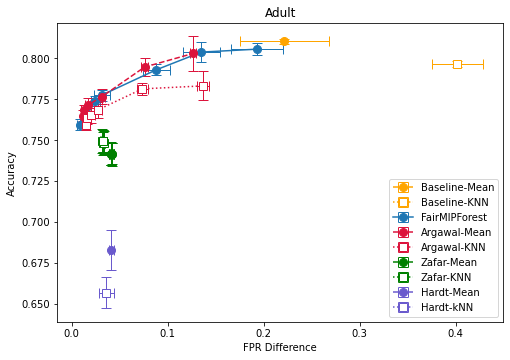

In [87]:
plt.figure(figsize=(8,5.5))


plt.errorbar(mean_fr_mean, mean_acc_mean, xerr =mean_fr_se, yerr=mean_acc_se, 
             fmt="--o", label='Baseline-Mean', color='orange',
            elinewidth=1,  markersize=8, capsize=5)
plt.errorbar(knn_fr_mean, knn_acc_mean, xerr =knn_fr_se, yerr=knn_acc_se, 
             fmt=":s", label='Baseline-KNN', color='orange', markerfacecolor='white',
            elinewidth=1,  markersize=8, capsize=5)

plt.errorbar(mip_result['fr_mean'], mip_result['acc_mean'], 
             xerr =mip_result['fr_se'], yerr=mip_result['acc_se'], 
             fmt="-o", label='FairMIPForest', elinewidth=1,  markersize=8, capsize=5)

plt.errorbar(exp_result['fr_mean'], exp_result['acc_mean'], 
             xerr =exp_result['fr_se'], yerr=exp_result['acc_se'], 
             fmt="--o", label='Argawal-Mean', color='crimson', 
            elinewidth=1,  markersize=8, capsize=5)
plt.errorbar(knn_exp_result['fr_mean'], knn_exp_result['acc_mean'], 
             xerr =knn_exp_result['fr_se'], yerr=knn_exp_result['acc_se'], 
             fmt=":s", label='Argawal-KNN', color='crimson', markerfacecolor='white',
            elinewidth=1,  markersize=8, capsize=5)
plt.errorbar(disp_mis_result['fr_mean'], disp_mis_result['acc_mean'], 
             xerr =disp_mis_result['fr_se'], yerr=disp_mis_result['acc_se'], 
             fmt="--o", label='Zafar-Mean', color='green',
            elinewidth=1,  markersize=8, capsize=5)
plt.errorbar(knn_disp_mis_result['fr_mean'], knn_disp_mis_result['acc_mean'], 
             xerr =knn_disp_mis_result['fr_se'], yerr=knn_disp_mis_result['acc_se'], 
             fmt=":s", label='Zafar-KNN', color='green', markerfacecolor='white',
            elinewidth=1,  markersize=8, capsize=5)
plt.errorbar(eqodds_result['fr_mean'], eqodds_result['acc_mean'], 
             xerr =eqodds_result['fr_se'], yerr=eqodds_result['acc_se'], 
             fmt="--o", label='Hardt-Mean', color='slateblue',
            elinewidth=1,  markersize=8, capsize=5)
plt.errorbar(knn_eqodds_result['fr_mean'], knn_eqodds_result['acc_mean'], 
             xerr =knn_eqodds_result['fr_se'], yerr=knn_eqodds_result['acc_se'], 
             fmt=":s", label='Hardt-kNN', color='slateblue', markerfacecolor='white',
            elinewidth=1,  markersize=8, capsize=5)


# plt.legend()
plt.legend(loc='lower right')
plt.xlabel('FPR Difference')
plt.ylabel('Accuracy')
plt.title('Adult')